In [268]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [269]:
import tensorflow as tf
import tensorflow.keras as keras
from utils import DenseRagged, PermopRagged
from utils import sep_dist, measure_dist
from utils import sym_KL

from tensorflow.keras.regularizers import l1, l2

import mtd
import numpy as np
from scipy.stats import entropy

from tqdm import tqdm
import time

import matplotlib.pyplot as plt
from matplotlib import gridspec

from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances
import seaborn as sns

import torch

import ot



# sns.set_theme(style="darkgrid")
FIG_SIZE = (18,5)
sns.set_context("talk")
plt.style.use('ggplot')

In [270]:
N_points     = 600

In [271]:
import pickle
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_data.npy', 'rb') as f:
    data_train = np.load(f)
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_label.npy', 'rb') as f:
    label_train = np.load(f)
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_indexes.npy', 'rb') as f:
    train_indexes = np.load(f)
with open("RipsNet_exp/cross_pd_circles_3000_strat_boost_10_PD.txt", 'rb') as fp:   #Pickling
    train_PD = pickle.load(fp)

In [272]:
n_boostrap = 10
# train_PD_1 = [x[1] if len(x[1])>0 else np.array([[0., 0.]]) for x in train_PD ]
train_PD_1 = [[x[1] if len(x[1])>0 else np.array([[0., 0.]]) for x in barcs ] for barcs in train_PD]

In [285]:
from scipy import stats

mtds = [[mtd.get_score(barc, 1, 'sum_length') for barc in barcs] for barcs in train_PD]

full_values = np.stack(mtds).ravel()

min_v, max_v = min(full_values), max(full_values)

mtds_kde_density = [stats.gaussian_kde(values) for values in mtds]

positions = np.linspace(2, max_v, num = 1000)

mtd_densities = [density(positions) for density in mtds_kde_density]

mtd_densities = [density/np.sum(density) for density in mtd_densities]

In [286]:
mtd_train = np.vstack([mtd_densities[:800], mtd_densities[1000:1800], mtd_densities[2000:2800]])
clean_mtd_test = np.vstack([mtd_densities[800:1000], mtd_densities[1800:2000], mtd_densities[2800:3000]])

In [287]:
data_train_concat = np.array([np.vstack((data_train[i],data_train[j])) for i,j in np.vstack([train_indexes[:800], train_indexes[1000:1800], train_indexes[2000:2800]])])
data_test_concat = np.array([np.vstack((data_train[i],data_train[j])) for i,j in np.vstack([train_indexes[800:1000], train_indexes[1800:2000], train_indexes[2800:3000]])])

In [288]:
tf_data_train_1 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, :N_points])] for i in range(len(data_train_concat))], ragged_rank=1)
tf_data_train_2 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, N_points:])] for i in range(len(data_train_concat))], ragged_rank=1)


tf_data_test_1 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, :N_points])] for i in range(len(data_test_concat))], ragged_rank=1)
tf_data_test_2 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, N_points:])] for i in range(len(data_test_concat))], ragged_rank=1)

In [289]:
start_time = time.time()
pdist_train = np.zeros((data_train_concat.shape[0], N_points, 2*N_points))
for i in tqdm(range(data_train_concat.shape[0]), desc = "pdist for train dataset"):
    cloud_1 = data_train_concat[i, :N_points]
    cloud_2 = data_train_concat[i, N_points:]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    # pdist_train.append(d)
    pdist_train[i, :, :] = d[N_points:, :] ## because all upper numbers equal to zero

pdist_test = np.zeros((data_test_concat.shape[0], N_points, 2*N_points))
for i in tqdm(range(data_test_concat.shape[0]), desc = "pdist for test dataset"):
    cloud_1 = data_test_concat[i, :N_points]
    cloud_2 = data_test_concat[i, N_points:]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    pdist_test[i, :, :] = d[N_points:, :] ## because all upper numbers equal to zero
    
print("Distance maatrix calculationn took --- %s seconds ---" % (time.time() - start_time))

pdist for test dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 100.36it/s]

Distance maatrix calculationn took --- 31.649632930755615 seconds ---


In [290]:
n_features = 60

In [291]:
start_time = time.time()

percentiles = np.linspace(0, 100, n_features)

pdist_train_reducted_quant = np.percentile(pdist_train, percentiles, axis=-1, method = "closest_observation").transpose((1,2,0))
pdist_test_reducted_quant = np.percentile(pdist_test, percentiles, axis=-1,  method = "closest_observation").transpose((1,2,0))

print("Distance matrix reducted by Quantile for --- %s seconds ---" % (time.time() - start_time))

Distance matrix reducted by Quantile for --- 150.35251450538635 seconds ---


---

In [306]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                                            patience=100, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=True)

dropout_rate = 0.2
optim = tf.keras.optimizers.Adamax(learning_rate=1e-4)
inputs_1 = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)
inputs_2 = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)
inputs_dist = tf.keras.Input(shape=(N_points, 60), dtype ="float32", ragged=False)

x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_1)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)

y = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_2)
y = DenseRagged(units=20, use_bias=True, activation='relu')(y)
y = DenseRagged(units=10, use_bias=True, activation='relu')(y)
y = PermopRagged()(y)

x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=20, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=10, use_bias=True, activation='relu')(x_y)
x_y= PermopRagged()(x_y)

d = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_dist)
d = DenseRagged(units=20, use_bias=True, activation='relu')(d)
d = DenseRagged(units=10, use_bias=True, activation='relu')(d)
d = PermopRagged()(d)


z = keras.layers.Concatenate(axis=-1)([x, y, x_y, d])

# z = keras.layers.Concatenate(axis=-1)([x, y, x_y])
z = tf.keras.layers.Normalization()(z)
z = tf.keras.layers.Dense(150,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(dropout_rate)(z)
outputs = tf.keras.layers.Dense(mtd_train.shape[1], activation='sigmoid')(z)
outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

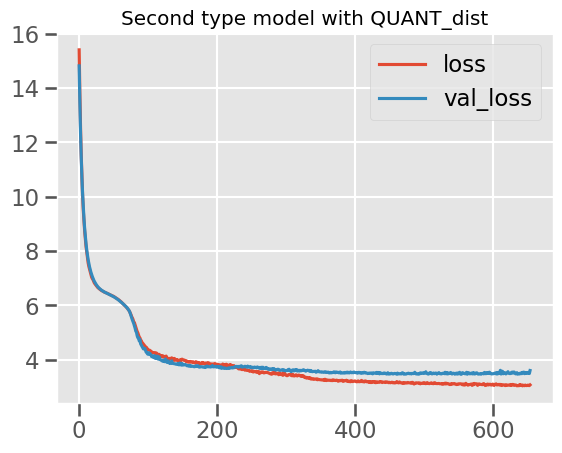

Last train loss: 3.07 and val loss: 3.60
Model fitted for --- 1149.666363477707 seconds ---


In [307]:
start_time = time.time()

model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss=sym_KL)

history_quant = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted_quant], mtd_train, epochs=3000, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted_quant], clean_mtd_test), callbacks=[callback], verbose=0)

train_mtd_prediction_second_type_quant = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted_quant])
clean_mtd_prediction_second_type_quant = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted_quant])


plt.plot(np.array(history_quant.history["loss"][20:]))
plt.plot(np.array(history_quant.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.title("Second type model with QUANT_dist")
plt.show()

val_loss = history_quant.history["val_loss"][-1]
train_loss = history_quant.history["loss"][-1]

print(f"Last train loss: {train_loss:.2f} and val loss: {val_loss:.2f}")

print("Model fitted for --- %s seconds ---" % (time.time() - start_time))

Графики сохранены!


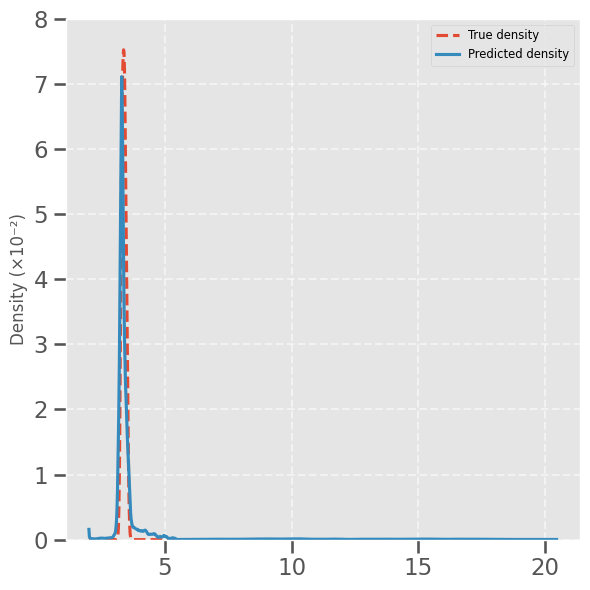

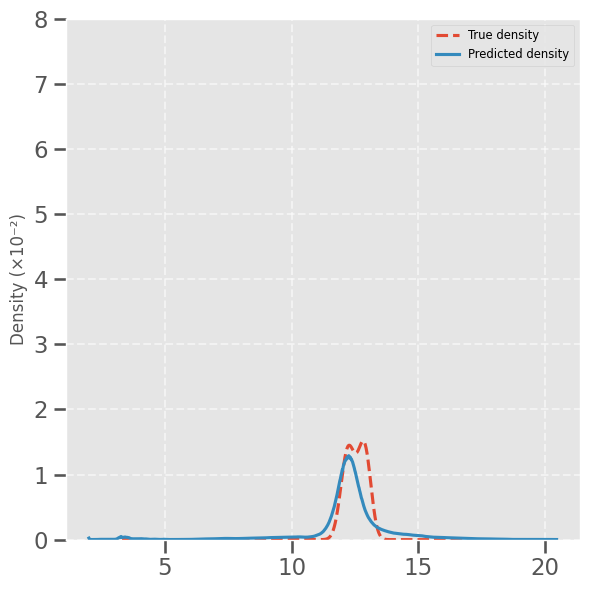

In [364]:
for i, index in enumerate(indexes):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    mtd_true = clean_mtd_test[index]*100
    mtd_predicted = clean_mtd_prediction_second_type_quant[index]*100
    
    # Построение графиков
    ax.plot(positions, mtd_true, label="True density", linestyle="--")
    ax.plot(positions, mtd_predicted, label="Predicted density")
    if i==0:
        # Настройка шкалы Y в формате 1e-2
        y_min = min(np.min(mtd_true), np.min(mtd_predicted))
        y_max = max(np.max(mtd_true), np.max(mtd_predicted))
        
        # Округляем границы до шага 0.01
        y_min = np.floor(y_min)
        y_max = np.ceil(y_max)
    
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max + 1, 1))  # Шаг 0.01
    
    # Форматирование подписей оси Y
    # ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))  # Два знака после запятой
    ax.set_ylabel("Density (×10⁻²)", fontsize=12)  # Явное указание масштаба
    
    # Остальные настройки
    ax.legend(fontsize="small")
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Сохранение
    plt.tight_layout()
    plt.savefig(f"MTD_density_predicted_{i}.png", dpi=600, bbox_inches='tight')
    # plt.close(fig)

print("Графики сохранены!")